<a href="https://colab.research.google.com/github/arneeichholtz/BERTopic_evaluation/blob/main/topic_modeling_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Topic Modeling with BERT**

This python notebook contains the code for topic modeling with BERT. It contains the following sections:

1. Data functions: defining functions to get data.
2. Manual: topic modeling with BERT sentence embeddings but manually constructing topics.
3. BERTopic: topic modeling using BERTopic python module.

##**1. Data functions**

Section 1 contains the functions to read the input data.

In [76]:
# Functions to get input text

def read_input_texts(folder):
    text_names = sorted([text_file for text_file in os.listdir(folder) if text_file.endswith('.txt')])
    print(f'{"Number of texts in folder:":<65}{len(text_names):>10}')

    texts = []
    for text in text_names:
        with open(os.path.join(folder, text), "r", encoding="utf-8") as file:
            text_body = file.read()
        texts.append(text_body)
    return texts

def chunk_texts(texts, max_len):
    out = []
    for text in texts:
        chunks = make_chunks(text, max_len)
        out.extend(chunks)
    print(f'{"Number of shortened texts to process:":<65}{len(out):>10}')
    return out

def make_chunks(text, max_length):
    chunks = []
    while text:
        chunk = text[:max_length]
        chunks.append(chunk)
        text = text[max_length:]
    return chunks

def sentencize_text(texts):
    return [sentence for t in texts for sentence in t.split(".")]

def pair_sentences(sentences):
    return [(sentences[i]+""+sentences[i+1] if i+1 < len(sentences) else sentences[i]) for i in range(0, len(sentences), 2)]

##**2. Manual**

Section 2 is Manual Topic modeling with BERT. Generating sentence embeddings based on BERT and constructing topics manually using c-TF-IDF algorithm.

In [13]:
# Installing packages

# !pip install sentence_transformers
# !pip install umap-learn
# !pip install hdbscan

In [3]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
import json
import time
from datetime import date

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
# Parameters

random_state = 0  # Random state for reproducability, used for UMAP
bert_model = 'distilbert-base-nli-mean-tokens'

# Text section size to use for embeddings. Options: chunk, sentence, sentence-pairs
emb_text_size = "chunk"
# emb_text_size = "sentence"
# emb_text_size = "sentence-pairs"

chunk_size = 1000

In [77]:
# Creating embeddings

if f"embeddings_{emb_text_size}.pkl" in os.listdir(os.getcwd()):  # If embeddings generated prior
    print("Reading embeddings from folder...")
    with open(f"embeddings_{emb_text_size}.pkl", "rb") as file:
        data_dict = pickle.load(file)
        data = data_dict['data']
        emb_text_size = data_dict['embedding-text-size']
        embeddings = data_dict['embeddings']

else:
    folder = "/content/text_bodies"
    if os.path.exists(folder):
        texts = read_input_texts(folder)
        model = SentenceTransformer(bert_model)

        if emb_text_size in ["chunk", "sentence", "sentence-pairs"]:
            if emb_text_size == "chunk":
                data = chunk_texts(texts, max_len=chunk_size)
                embeddings = model.encode(data, show_progress_bar=True)
            elif emb_text_size == "sentence":
                data = sentencize_text(texts)
                embeddings = model.encode(data, show_progress_bar=True)
            else:  # emb_text_size = "sentence-pairs":
                sentences = sentencize_text(texts)
                data = pair_sentences(sentences)
                embeddings = model.encode(data, show_progress_bar=True)

            with open(f"embeddings_{emb_text_size}.pkl", "wb") as file:
                pickle.dump({'data': data, 'embeddings': embeddings, 'embedding-text-size': emb_text_size}, file, protocol=pickle.HIGHEST_PROTOCOL)

        else:
            print("This embedding text size is undefined.")

    else:
        print("The folder text_bodies does not exist. Upload it.")

print(f"Embeddings shape: {embeddings.shape}")

The folder text_bodies does not exist. Upload it.
Embeddings shape: (24367, 768)


In [ ]:
# Reducing dimensionality of data to dim=5 using UMAP
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine',
                            random_state=random_state).fit_transform(embeddings)

In [ ]:
# Clustering data using HDBSCAN
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

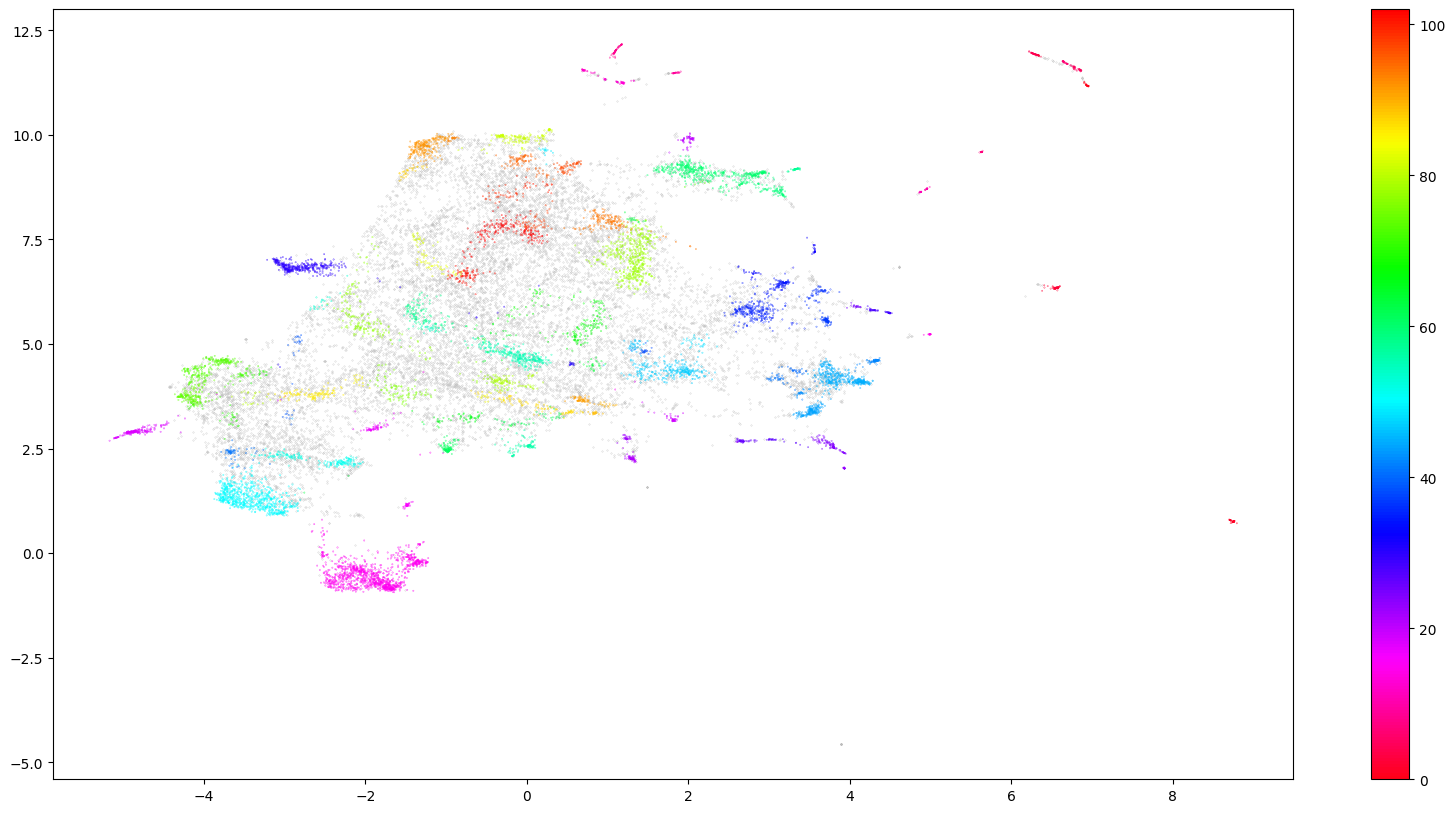

In [ ]:
# Preparing data
# Map data onto 2 dimensions
umap_data = umap.UMAP(n_neighbors=15,
                      n_components=2,
                      min_dist=0.0,
                      metric='cosine',
                      random_state=random_state).fit_transform(embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

In [ ]:
# Creating a single document for each cluster of documents

docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
# c-TF-IDF Function. Calculate tf-idf score (importance value) for each word

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [ ]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [ ]:
# Functions to extract words from topic clusters

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [ ]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)

print(f'Number of topics found: {topic_sizes.shape[0]-1}\n')
print(topic_sizes.head(10))

Number of topics found: 103

    Topic   Size
0      -1  14153
16     15   1165
51     50    733
79     78    494
61     60    481
46     45    411
31     30    385
56     55    302
48     47    282
36     35    253


In [ ]:
# Topic indices
topic_inds = topic_sizes.head(10)["Topic"][1:].values
print(f"Topic indices: {topic_inds}\n")

for topic in topic_inds:
  words = [t[0] for t in top_n_words[topic][:10]]
  print(f"Topic {topic}: ", ", ".join(words))

Topic indices: [15 50 78 60 45 30 55 47 35]

Topic 15:  nuclear, weapons, india, pakistan, indian, decision, missile, deterrence, missiles, force
Topic 50:  china, chinese, beijing, taiwan, relations, strategy, government, foreign, approach, policy
Topic 78:  energy, solar, 2050, 2030, electricity, emissions, capacity, hydrogen, gw, scenario
Topic 60:  cannabis, drug, use, cocaine, cultivation, methamphetamine, drugs, cent, seizures, treatment
Topic 45:  journal, dc, washington, migration, paper, economics, bank, review, world, 2021
Topic 30:  automation, agricultural, producers, technologies, agriculture, mechanization, farmers, machinery, digital, farm
Topic 55:  urban, cities, futures, city, health, sustainable, inclusive, future, governance, planning
Topic 47:  eu, european, 2022, 2023, council, commission, defence, security, cooperation, development
Topic 35:  gdp, imf, year, 2023, percent, note, real, table, staff, projections


In [ ]:
print(top_n_words[15][:10])
print(top_n_words[50][:10])
print(top_n_words[78][:10])

[('nuclear', 0.06624552920609215), ('weapons', 0.036693415346973825), ('india', 0.02845096132659569), ('pakistan', 0.025331844875929176), ('indian', 0.02128982033553672), ('decision', 0.016934666908968308), ('missile', 0.015774618676374228), ('deterrence', 0.014950859301044495), ('missiles', 0.014890983139346123), ('force', 0.011118363196315708)]
[('china', 0.045358901335765596), ('chinese', 0.026744591855862705), ('beijing', 0.018542988058371967), ('taiwan', 0.014577723917581914), ('relations', 0.013736069584272275), ('strategy', 0.010451293321021194), ('government', 0.009737027893229083), ('foreign', 0.00952115288149942), ('approach', 0.009470565933267646), ('policy', 0.009362472626801104)]
[('energy', 0.028059791505876546), ('solar', 0.022322498168793038), ('2050', 0.021485334878550012), ('2030', 0.02131320631612886), ('electricity', 0.02007307932507933), ('emissions', 0.016370116293687988), ('capacity', 0.015684115436741204), ('hydrogen', 0.015163471101379531), ('gw', 0.01489847614

In [ ]:
# Topic Reduction by merging similar topics together

for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

In [ ]:
topic_sizes = extract_topic_sizes(docs_df)
print(f'After merging topics, number of topics found: {topic_sizes.shape[0]-1}\n')
print(topic_sizes.head(10))

After merging topics, number of topics found: 83

    Topic   Size
0      -1  14191
14     13   1165
44     43    752
54     53    496
67     66    494
40     39    428
27     26    385
49     48    302
42     41    282
30     29    253


In [ ]:
# Topic indices
topic_inds = topic_sizes.head(10)["Topic"][1:].values
print(f"Topic indices: {topic_inds}\n")

for topic in topic_inds:
  words = [t[0] for t in top_n_words[topic][:10]]
  print(f"Topic {topic}: ", ", ".join(words))

Topic indices: [13 43 53 66 39 26 48 41 29]

Topic 13:  nuclear, weapons, india, pakistan, indian, decision, missile, deterrence, missiles, force
Topic 43:  china, chinese, beijing, taiwan, relations, strategy, foreign, government, bri, approach
Topic 53:  cannabis, drug, use, cocaine, cultivation, drugs, methamphetamine, cent, seizures, treatment
Topic 66:  energy, solar, 2050, 2030, electricity, emissions, capacity, hydrogen, gw, scenario
Topic 39:  journal, dc, economics, washington, migration, paper, bank, review, world, research
Topic 26:  automation, agricultural, producers, technologies, agriculture, mechanization, farmers, machinery, digital, farm
Topic 48:  urban, cities, futures, city, health, sustainable, inclusive, future, governance, planning
Topic 41:  eu, european, 2022, 2023, council, commission, defence, security, cooperation, development
Topic 29:  gdp, imf, year, 2023, percent, note, real, table, staff, projections


##**3. BERTopic**

Section 3 is Topic modeling with BERTopic. Using the BERTopic Python module to easily extract topics from text data.

TODO:
- Coherence score, NMPI; some metric to evaluate iterations of topic modeling output
- Improve merging based on hierarchical output. Interesting options here. Can go quite far.
- Layout with merging; make sure to show when data is merged, re-running.

In [6]:
# Installing packages

# !pip install bertopic

In [5]:
# Imports

from bertopic import BERTopic

###Reading data, embeddings, model

In [7]:
# Parameters

model_from_file = True  # Use topic_model from file or not
red_embeddings_from_file = True  # Use reduced-embeddings from file or not

In [8]:
# Connecting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/topic-modeling-bert"
folder_path

'/content/drive/MyDrive/Colab Notebooks/topic-modeling-bert'

In [78]:
# Topic Modeling with BERTopic. Module handles embeddings creation, clustering, dim-reduction, and plotting/visualization.

if model_from_file:
  print("Reading topic-model from file...")
  start = time.time()
  topic_model = BERTopic.load(os.path.join(folder_path, "bertopic_model"))
  merged = False
  print(f"Time elapsed to load topic-model: {time.time() - start:.3f} seconds")
else:
  print("Initializing topic-model at runtime...")
  topic_model = BERTopic()

  max_len = 1000
  folder = "/content/text_bodies"
  texts = read_input_texts(folder)
  data = chunk_texts(texts, max_len)

  topics, probs = topic_model.fit_transform(data)

  # Saving topic_model
  topic_model.save("/content/bertopic_model_sjl", serialization="joblib")

Reading topic-model from file...
Time elapsed to load topic-model: 5.179 seconds


In [79]:
# embeddings_chunk was generated on local device because of quicker runtime -- see code block Creating embeddings in Section 2
# It contains a pickled dict with 'data', 'embeddings', 'embedding-text-size'.

with open(os.path.join(folder_path ,"embeddings_chunk.pkl"), "rb") as file:
    data_dict = pickle.load(file)
    texts = data_dict['data']
    embeddings = data_dict['embeddings']

# Reduced dimensionality embeddings
if red_embeddings_from_file:
  reduced_embeddings = np.load(os.path.join(folder_path, "reduced_embeddings.npy"))
else:
  # Reduce embeddings to dim=2
  reduced_embeddings = umap.UMAP(n_neighbors=10,
                                 n_components=2,
                                 min_dist=0.0,
                                 metric='cosine',
                                 random_state=random_state).fit_transform(embeddings)

  # Saving reduced embeddings to file
  np.save('/content/reduced_embeddings.npy', reduced_embeddings)

###Plotting

In [ ]:
# Testing for plotting

# TO TRY
#
# Functions:
# .reduce_topics(docs, nr_topics=30) to reduce num of topics
# .reduce_outliers(docs, topics) data does contain some outliers
#
# Attributes:
# .topic_representations_(): The top n terms per topic and their respective c-TF-IDF values.


In [80]:
# Using a default visualization, visualize_topics()

topic_model.visualize_topics()

In [81]:
# FUNCTIONS for plotting
def top_n_words(topic_model, n_topics=10, n_words=10):
  """Get top n words from topics"""
  topic_words = topic_model.topic_representations_
  top_n_topics = {k:topic_words[k] for k in range(-1, n_topics)}  # From -1 because topic indexing starts at -1

  words_out = []  # 2-D out list with description words
  for values in top_n_topics.values():
    tuples = values[0:n_words]  # Tuples of words and probability
    words = [t[0] for t in tuples] # Saving only the words
    words_out.append(words)
  return words_out

def first_at_end(lst):
  """Append the first element of list at the end"""
  lst.append(lst.pop(0))
  return lst

In [82]:
# PARAMETERS for plotting
hide_document_hover = False
use_custom_labels = True
custom_label_type = "Des"  # Description
n_total = 50  # Total number of topics to show in the fig
sample = 0.8
n_words_legend = 3 # Number of words to use in the description in the legend
n_words_hover = 6 # Number of words to display when hovering over figure
plot_non_docs = False  # Whether to plot docs not classified to a topic

In [105]:
# PLOTTING
info = topic_model.get_topic_info()
num_topics = info.shape[0] - 1 # -1 because indexing of topics starts at -1. All words without topic are assigned to topic with id=-1
print(f"Number of topics found: {num_topics}")

# Custom labels for legend
# This can still be changed. Preferably with a prompt of GPT API, something like:
# "Summarise the following words in a single topic word or phrase: {words[i] for i in range(num_topics)}"
words_legend = top_n_words(topic_model, n_topics=num_topics, n_words=n_words_legend)
legend_labels = [f"{i}: "+", ".join(w) for i, w in enumerate(words_legend)]

# Custom labels for hover
words_hover = top_n_words(topic_model, n_topics=num_topics, n_words=n_words_hover)
hover_labels_text = [" | ".join(w) for w in words_hover]  # Top 6 words separated by |
hover_labels_text = first_at_end(hover_labels_text) # Add first element 'the|of|and..' to and of list; its topics id=-1, so the elements are indexed by topic id

counts = topic_model.topic_sizes_  # Count or size of all topics
size_non_topic = counts[-1]  # The non-topic is indexed at -1
total = len(texts) - size_non_topic  # Total is the total number of classified documents, so subtract size of non-topic docs
hover_labels_size = [words+f" - Topic size: {counts[i]/total*100:.2f}%" for i, words in enumerate(hover_labels_text)]  # Combining words and topic size in single str

# Setting hover_labels and plot_embeddings
topics = np.array(topic_model.topics_)  # Topic id for each document, [-1, -1, 58, 17, 23, -1, ...]
hover_labels = [hover_labels_size[t] if t != -1 else "" for t in topics]  # Indexing the hover labels by topic id, excluding -1 because this is non topic
docs_topic = len(hover_labels) - hover_labels.count("")  # Nr of docs classified to a topic

if not plot_non_docs:
  # NumPy implementation below 20x faster than lst comphrehension
  plot_embeddings = reduced_embeddings.copy()
  plot_embeddings[(topics == -1) | (topics >= n_total)] = 0  # Set embedding to 0 when id=-1 or id >= n_total
  print(f"Plotting only documents classified to a topic. Number of docs: {docs_topic}")
else:
  plot_embeddings = reduced_embeddings
  print(f"Plotting all documents. Number of docs: {len(hover_labels)}")

# Plotting
topic_model.set_topic_labels(legend_labels)  # legend_labels contains '0: the, and, of' but this is skipped automatically
fig_title = "Text Data | Documents & Topics (merged)" if merged else "Text Data | Documents & Topics (unmerged)"
topic_model.visualize_documents(hover_labels,
                                reduced_embeddings=plot_embeddings,
                                hide_document_hover=hide_document_hover,
                                custom_labels=use_custom_labels,
                                topics=range(n_total),
                                sample=sample,
                                title=fig_title)

Number of topics found: 135
Plotting only documents classified to a topic. Number of docs: 12406


In [84]:
# Saving the interactive figure

fig = topic_model.visualize_documents(hover_labels,
                                      reduced_embeddings=plot_embeddings,
                                      hide_document_hover=hide_document_hover,
                                      custom_labels=use_custom_labels,
                                      topics=range(n_total),
                                      sample=sample,
                                      title=fig_title)

# fig.write_html(f"/content/plot_hdh{hide_document_hover}_cl{use_custom_labels}_clt{custom_label_type}_n{n_total}_s{sample}_m{merged}_d{date.today()}.html")

###Merging topics together

In [96]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

from scipy.cluster import hierarchy as sch


In [85]:
def calculate_coherence(topic_model):
  topics = np.array(topic_model.topics_)
  documents = pd.DataFrame({"Document": texts,
                          "ID": range(len(texts)),
                          "Topic": topics})
  documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
  cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

  # Extract vectorizer and analyzer from BERTopic
  vectorizer = topic_model.vectorizer_model
  analyzer = vectorizer.build_analyzer()

  # Extract features for Topic Coherence evaluation
  words = vectorizer.get_feature_names_out()
  tokens = [analyzer(doc) for doc in cleaned_docs]
  dictionary = corpora.Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]
  topic_words = [[words for words, _ in topic_model.get_topic(topic)]
                for topic in range(len(set(topics))-1)]

  coherence_model = CoherenceModel(topics=topic_words,
                                   texts=tokens,
                                   corpus=corpus,
                                   dictionary=dictionary,
                                   coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

In [106]:
# Reading topic model from file again
topic_model = BERTopic.load(os.path.join(folder_path, "bertopic_model"))
merged = False

In [107]:
# Merging topics that are closer together than 0.5 in the hierarchy

linkage_f = 'complete'  # single, complete, average, or ward
linkage_function = lambda x: sch.linkage(x, linkage_f, optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(texts, linkage_function=linkage_function)


100%|██████████| 191/191 [00:02<00:00, 69.53it/s]


In [108]:
# Visualize hierarchical topic modeling

topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [99]:
hierarchical_topics.tail()

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
4,157,regions_nuts_were_eu_region,"[30, 96]",30,regions_nuts_were_eu_recorded,96,regions_deaths_inhabitants_nuts_crashes,0.384940
3,156,destination_migrants_refugees_match_workers,"[28, 34]",28,destination_migrants_match_refugees_origin,34,workers_work_refugees_migrants_match,0.376257
2,155,inflation_percent_growth_2023_economies,"[4, 12]",12,gdp_imf_2023_percent_real,4,inflation_growth_percent_2023_financial,0.344074
1,154,parity_gender_score_benchmark_life,"[41, 45]",45,parity_gender_benchmark_score_indicators,41,score_gender_participation_parity_rank,0.314995
0,153,nrolment_education_participation_min_empowerment,"[32, 60]",60,value_nrolment_indicatorunit_employed_education,32,participation_nrolment_min_education_empowerment,0.268898


In [65]:


# hierarchical_topics["Topics_merge_len"] = hierarchical_topics["Topics"].apply(len)
# hierarch_topics_sorted = hierarchical_topics.sort_values(by=['Topics', 'Distance'],
#                            key=lambda x: (x.map(len) if x.name == 'Topics' else x))
# hierarch_topics_sorted.head(60)

In [90]:
def find_unique_ids(lst: list[list[int]]):
  """Finds collections of ids that are longest and unique"""
  lst.sort(key=len, reverse=True)
  ids = set()
  out_list = []
  for element in lst:
    if not any(i in ids for i in element):
      ids.update(element)
      out_list.append(element)
  return out_list

test = [[40, 109], [120, 191], [90, 98], [40, 109, 186]]
find_unique_ids(test)  # Removes [40, 109]

[[40, 109, 186], [120, 191], [90, 98]]

In [100]:
# IMPROVE topics to merge

# df_lower = hierarchical_topics[hierarchical_topics['Distance'] < 0.5]
# topics_column_low = df_lower['Topics'].to_list()
# print(topics_column_low)

# df_higher = hierarchical_topics[hierarchical_topics['Distance'] >= 0.5]
# topics_column_high = df_higher['Topics'].to_list()
# print(topics_column_high)

# Try: only keep topic ids if they do not appear in a merger with distance larger than 0.5. Think about how to do this. Hierarchical topics is useful.

# max_merge = 5  # Maximum number of topics to merge
# distance_cutoff = 0.5
# topics_sets = []

# df_filtered = hierarch_topics_sorted[
#     (hierarch_topics_sorted["Topics_merge_len"] >= 2) &
#     (hierarch_topics_sorted["Topics_merge_len"] <= max_merge) &
#     (hierarch_topics_sorted["Distance"] < distance_cutoff)
# ]

# df_filtered.shape
# topic_sets = df_filtered["Topics"].to_list()
# topics_to_merge = find_unique_ids(topic_sets)
# topics_to_merge

hierarch_topics_filtered = hierarchical_topics[hierarchical_topics["Distance"] < 0.5]
topic_sets = hierarch_topics_filtered["Topics"].to_list()
topics_to_merge = find_unique_ids(topic_sets)


In [92]:
# Filtering hierarchical df to find topics to merge

# df = hierarchical_topics[hierarchical_topics['Distance'] < 0.5]
# df.drop(df.columns.difference(['Child_Left_ID', 'Child_Right_ID']), 1, inplace=True)
# df = df.astype(int)
# df = df[(df['Child_Left_ID'] <= 191) & (df['Child_Right_ID'] <= 191)]
# topics_to_merge = df.values.tolist()  # Topics to merge
# topics_to_merge

In [101]:
# Adding it to topic-model object
topic_model.merge_topics(texts, topics_to_merge)
merged = True

In [103]:
# Visualizing the merged topics
# To visualize the merged topics in the doc scatter plot with custom hover and labels, run plotting code cell above
# If you wish to visualize the unmerged topics again, run the code cell above to read the bertopic_model from file again.

fig_title = "Intertopic Distance Map | Merged Topics" if merged else "Intertopic Distance Map | Unmerged Topics"
topic_model.visualize_topics(title=fig_title)

In [104]:
coherence = calculate_coherence(topic_model)
coherence

0.6786236471384564

In [169]:
linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(texts, linkage_function=linkage_function)

topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 167/167 [00:02<00:00, 62.15it/s]


In [170]:
hierarchical_topics

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
166,334,of_the_and_in_to,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",129,het_van_en_een_de,333,of_the_and_in_to,0.897197
165,333,of_the_and_in_to,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",332,of_the_and_in_to,158,bulletin_ns_nf_cu_ur,0.823227
164,332,of_the_and_in_to,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",331,of_the_and_in_to,141,former_chairman_minister_founder_president,0.812492
163,331,of_the_and_in_to,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",330,the_of_and_in_to,303,estimatescomparable_republic_estimatesprimary_...,0.810796
162,330,the_of_and_in_to,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",57,ag_ai_al_anan_alal,329,the_of_and_in_to,0.809223
...,...,...,...,...,...,...,...,...
4,172,parity_gender_benchmark_score_indicators,"[74, 75]",74,parity_gender_score_benchmark_rank,75,parity_sci_gender_benchmark_indicators,0.179412
3,171,participation_nrolment_min_education_empowerment,"[52, 71]",52,participation_nrolment_min_education_indicator...,71,nrolment_participation_min_rank_survival,0.163157
2,170,rights_value_equal_indicatorunit_access,"[30, 89, 91, 164]",169,rights_equal_value_access_indicatorunit,91,value_indicatorunit_employed_nrolment_rights,0.150441
1,169,rights_equal_value_access_indicatorunit,"[30, 89, 164]",168,rights_equal_value_access_indicator1,89,value_rights_indicatorunit_access_equal,0.147116


##**4. Evaluation**

Evaluating the topic output using gensim coherence, the BERTopic_evaluation Notebook and the Octis module. The Octis module contains metrics for classification, coherence, diversity, similarity, and Topic significance.


**BERTopic_evaluation Notebook**

Thus far I have been unable to get the topic-model evaluatiot notebook to work.

In [36]:
# %cd drive/MyDrive/Colab Notebooks/BERTopic_evaluation
!ls

/content/drive/MyDrive/Colab Notebooks/BERTopic_evaluation
evaluation  LICENSE  notebooks	README.md  results  setup.py


In [45]:
# from evaluation.evaluation import Trainer

In [24]:
dataset_name = "police-discourse"
custom_dataset = True

**gensim coherence**

From: https://www.theanalyticslab.nl/topic-modeling-with-bertopic/

In [25]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
help(BERTopic._preprocess_text)

In [133]:
documents = pd.DataFrame({"Document": texts,
                          "ID": range(len(texts)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

# Evaluate
# For c_npmi, values range between [-1, 1] where 1 indicates perfect association. Reasonably good values are between 0.15-0.20,
# based on the BERTopic paper.
# For c_v, values range between [0, 1] where 1 indicates perfect association. Reasonably good performance is coherence > 0.5
coherence_metrics = ['c_v', 'c_npmi']

for metric in coherence_metrics:
  coherence_model = CoherenceModel(topics=topic_words,
                                  texts=tokens,
                                  corpus=corpus,
                                  dictionary=dictionary,
                                  coherence=metric)
  coherence = coherence_model.get_coherence()
  print(f"Coherence score {metric}: {coherence:.4f}")

Coherence score c_v: 0.7110
Coherence score c_npmi: 0.1191


**Octis Module**

Thus far I have only been able to calculate Topic Diversity using Octis, for Topic Coherence it is unclear how the data should be formatted.

In [30]:
# !pip install octis

In [125]:
import octis
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity


In [129]:
# Get topic output as 2d lst for TopicDiversity model
words_output = []  # 2-D list with topic words
for id, distribution in topic_model.get_topics().items():
  words = [tuple[0] for tuple in distribution]
  words_output.append(words)

model_output = {"topics": words_output}

In [130]:
# Calculate Topic Diversity
# Values range between [0, 1], where 1 indicates varied topics. Reasonably good values are between 0.80-0.90.
# Note that optimizing for diversity and coherence might be incompatible.

metric = TopicDiversity(topk=5) # Initialize metric
topic_diversity_score = metric.score(model_output) # Compute score of the metric
print(f"Topic Diversity: {topic_diversity_score:.4f}")

Topic Diversity: 0.6549


In [121]:
# Function used for Octis coherence
# NOT USED

# # Removing \t for corpus.tsv
# def remove_tabs(text_documents):
#   return [document.replace("\t", "") for document in text_documents]

# # Make vocabulary vocab.txt from texts
# def create_vocabulary(documents, output_file_path):
#     """
#     Takes a list of text documents, extracts unique words from them, and
#     writes them into a .txt file, with each word on a new line.

#     :param documents: List[str] - a list of text documents.
#     :param output_file_path: str - path to the output .txt file.
#     """
#     # Extract unique words from documents
#     unique_words = set()
#     for doc in documents:
#         doc = doc.replace("\t", "")
#         words = doc.split()
#         unique_words.update(words)

#     # Write unique words to file
#     with open(output_file_path, 'w') as file:
#         for word in sorted(unique_words):
#             file.write(word + '\n')